# Bike Sharing Analysis

In [1]:
# supress warnings
import warnings
warnings.filterwarnings("ignore")


import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Understanding The Data

In [2]:
# load hourly data
hourly_data = pd.read_csv("data/hour.csv")
hourly_data

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,17375,2012-12-31,1,1,12,19,0,1,1,2,0.26,0.2576,0.60,0.1642,11,108,119
17375,17376,2012-12-31,1,1,12,20,0,1,1,2,0.26,0.2576,0.60,0.1642,8,81,89
17376,17377,2012-12-31,1,1,12,21,0,1,1,1,0.26,0.2576,0.60,0.1642,7,83,90
17377,17378,2012-12-31,1,1,12,22,0,1,1,1,0.26,0.2727,0.56,0.1343,13,48,61


In [3]:
hourly_data.shape

(17379, 17)

- Data contains 17379 rows and 17 columns

In [4]:
hourly_data.isnull().sum().sum()

0

- There are no missing values in the data

In [5]:
# .T is used to transpose the resulting data, hence columns become rows and vice versa.
hourly_data.describe().T

,count,mean,std,min,25%,50%,75%,max
instant,17379.0,8690.000000,5017.029500,1.00,4345.5000,8690.0000,13034.5000,17379.0000
season,17379.0,2.501640,1.106918,1.00,2.0000,3.0000,3.0000,4.0000
yr,17379.0,0.502561,0.500008,0.00,0.0000,1.0000,1.0000,1.0000
mnth,17379.0,6.537775,3.438776,1.00,4.0000,7.0000,10.0000,12.0000
hr,17379.0,11.546752,6.914405,0.00,6.0000,12.0000,18.0000,23.0000
holiday,17379.0,0.028770,0.167165,0.00,0.0000,0.0000,0.0000,1.0000
weekday,17379.0,3.003683,2.005771,0.00,1.0000,3.0000,5.0000,6.0000
workingday,17379.0,0.682721,0.465431,0.00,0.0000,1.0000,1.0000,1.0000
weathersit,17379.0,1.425283,0.639357,1.00,1.0000,1.0000,2.0000,4.0000
temp,17379.0,0.496987,0.192556,0.02,0.3400,0.5000,0.6600,1.0000


## Data Preprocessing

In this section, data will be transformed to more human-readable formats. This way hidden patterns and relationships might arise when data is wrangled correctly.

In [6]:
# crate data copy
preprocessed_data = hourly_data.copy()

# transform mappings
season_mapping = {1: 'winter', 2: 'spring', 3: 'summer', 4: 'fall'}
yr_mapping = {0: 2011, 1: 2012}
weekdays = {0: "sunday", 1: "monday", 2: "tuesday", 3: "wednesday", 
                4: "thursday", 5: "friday", 6: "saturday"}
weather_mapping = {1: "clear", 2: "cloudy", 3: "light_rain_snow",
                4: "heavy_rain_snow"}

# transform seasons
preprocessed_data['season'] = preprocessed_data['season'] \
                    .apply(lambda x:season_mapping[x])
# transform yr
preprocessed_data['yr'] = preprocessed_data['yr'] \
                    .apply(lambda x: yr_mapping[x])
# transform weekday
preprocessed_data['weekday'] = preprocessed_data['weekday'] \
                    .apply(lambda x: weekdays[x])
# tranform weathersit
preprocessed_data['weathersit'] = preprocessed_data['weathersit'] \
                    .apply(lambda x: weather_mapping[x])
# transform hum
preprocessed_data['hum'] = preprocessed_data['hum'] * 100
# transform windspeed
preprocessed_data['windspeed'] = preprocessed_data['windspeed'] \
                    * 67

columns = ['season', 'yr', 'weekday', 'weathersit', 'hum', \
                                            'windspeed']

preprocessed_data[columns].sample(10, random_state=42)

,season,yr,weekday,weathersit,hum,windspeed
12830,summer,2012,saturday,clear,27.0,12.9980
8688,winter,2012,monday,clear,41.0,15.0013
7091,fall,2011,friday,clear,66.0,19.0012
12230,spring,2012,tuesday,clear,52.0,23.9994
431,winter,2011,thursday,clear,56.0,26.0027
1086,winter,2011,friday,clear,72.0,19.0012
11605,spring,2012,thursday,clear,58.0,8.9981
7983,fall,2011,sunday,clear,87.0,0.0000
10391,winter,2012,wednesday,clear,68.0,12.9980
7046,fall,2011,wednesday,clear,71.0,15.0013


## Univariate Analysis

In [7]:
"""
assert that total numver of rides is equal to the sum of
registered and caual ones
"""
assert (
    preprocessed_data['casual'] \
        + preprocessed_data['registered'] \
    == preprocessed_data['cnt']).all(), \
    "Sum of casual and registered rides not equal " \
    "to total number of rides"

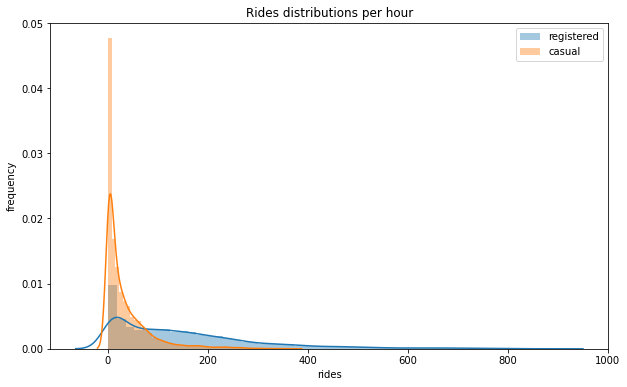

In [8]:
# plot distributions of registered vs casual rides
fig = plt.figure(figsize=(10,6))

sns.distplot(preprocessed_data['registered'], label="registered")
sns.distplot(preprocessed_data['casual'], label="casual")

plt.legend()
plt.xlabel('rides')
plt.ylabel('frequency')
plt.title("Rides distributions per hour")

plt.savefig("figs/rides_distribution.png")
plt.show()

- Registered users perform way more rides than casual ones
- Both distributions are skewed to the right, meaning, for most of the entries in the data, zero or a small number of rides were registered.
- Every entry has quite a large number of rides (that is, higher than 800)

### Evolution of rides over time

#### Number of rides each day

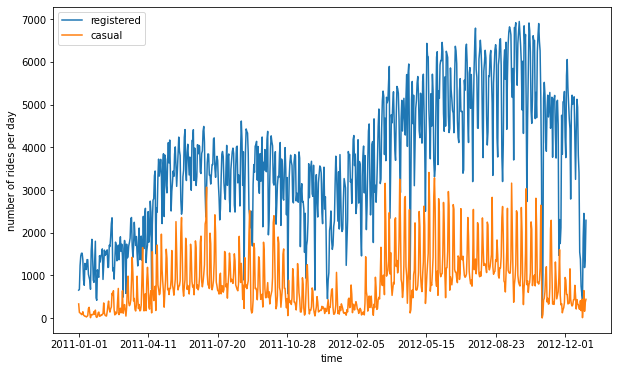

In [10]:
# plot evolution of rides over time
plot_data  = preprocessed_data[['registered', 'casual', 'dteday']]
ax = plot_data.groupby('dteday').sum().plot(figsize=(10,6))

ax.set_xlabel("time")
ax.set_ylabel("number of rides per day")

plt.savefig("figs/rides_daily.png", format='png')
plt.show()

- The number of registered rides is always significantly higher than the number of casual rides per day.
- During the winter, the overall number of rides decreases (which is totally in line with my expectation, as bad weather and low tempreatures have a negative impact on ride-sharing services).

#### Number of rides each day (smoothed)

With the lot of variance in the time series above, it's necessary to smooth out the curves by taking the rolling mean and standard deviation of the two time series and plot those instead.

This way, visualisation is not only possible for the average number of rides for a specific time period (also known as a **window**) but also the expected deviation from the mean.